In [4]:
import pandas as pd

# Read CSV file
df = pd.read_csv("beta_project_data.csv")

# Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Display first few rows
print(df.head())

# Show the overall time range
print("Time range:", df["Date"].min(), "to", df["Date"].max())
symbols = df["Symbol"].unique().tolist()
print(symbols)
print(len(symbols))

    Code Symbol       Date   Close     Volume  Adjustment Factor
0  59776    IBB 2014-06-06  246.09   674915.0                1.0
1  59593    AET 2012-10-04   42.09  7327759.0                1.0
2  57850    TXN 2015-10-12   51.34  4075340.0                1.0
3  62606     WW 2014-04-23   21.18   590148.0                1.0
4  59750    MDY 2010-08-17  135.89  2854263.0                1.0
Time range: 2010-01-04 00:00:00 to 2015-12-31 00:00:00
['IBB', 'AET', 'TXN', 'WW', 'MDY', 'XLE', 'HON', 'ORCL', 'MA', 'ICE', 'ATVI', 'GILD', 'ESRX', 'SBUX', 'WMT', 'AMGN', 'BRK.B', 'EFA', 'BMY', 'DAL', 'PFE', 'MSFT', 'NKE', 'QQQ', 'EOG', 'DXJ', 'MDLZ', 'WBA', 'KR', 'BAC', 'LBTY.K', 'BDX', 'TFCF.A', 'WFC', 'VWO', 'XLK', 'SIG', 'ABBV', 'TSLA', 'USB', 'BIDU', 'BIIB', 'TLT', 'XOP', 'SLB', 'GS', 'AMJ', 'DOW', 'DIA', 'PEP', 'WMB', 'LLY', 'AMZN', 'XIV', 'AXP', 'XLU', 'AABA', 'GE', 'OXY', 'MCD', 'MO', 'BHC', 'IBM', 'DWTI.F', 'VZ', 'AGN', 'V', 'IEF', 'VXX', 'XOM', 'MS', 'HD', 'DBEF', 'XLV', 'UAA', 'COST', 'HYG',

In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load data
df = pd.read_csv("beta_project_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Symbol", "Date"])

# Compute daily returns
df["Return"] = df.groupby("Symbol")["Close"].pct_change()

# Extract SPY returns
spy = df[df["Symbol"] == "SPY"][["Date", "Return"]].rename(columns={"Return": "SPY_Return"})
merged = df.merge(spy, on="Date", how="left")

# Rolling 45-day beta per symbol (strictly past data)
def rolling_beta(group):
    group = group.dropna(subset=["Return", "SPY_Return"]).copy()
    if len(group) < 45:
        group["Beta_45d_real"] = np.nan
        return group
    group["Beta_45d_real"] = (
        group["Return"].rolling(window=45, min_periods=45).cov(group["SPY_Return"])
        / group["SPY_Return"].rolling(window=45, min_periods=45).var()
    )
    return group

merged = merged.groupby("Symbol", group_keys=False).apply(rolling_beta)

# Rolling features using only past data
merged["Lag1"] = merged.groupby("Symbol")["Return"].shift(1)
merged["Lag2"] = merged.groupby("Symbol")["Return"].shift(2)
merged["Vol_5d"] = merged.groupby("Symbol")["Return"].rolling(window=5, min_periods=5).std().shift(1).reset_index(level=0, drop=True)
merged["Vol_10d"] = merged.groupby("Symbol")["Return"].rolling(window=10, min_periods=10).std().shift(1).reset_index(level=0, drop=True)
merged["Vol_SPY_10d"] = merged["SPY_Return"].rolling(window=10, min_periods=10).std().shift(1)

# Remove rows with NaN
merged = merged.dropna(subset=["Beta_45d_real", "Lag1", "Lag2", "Vol_5d", "Vol_10d", "Vol_SPY_10d"])

# Train/test using only past data — rolling approach
mse_results = {}
symbols = [s for s in merged["Symbol"].unique() if s != "SPY"]

for symbol in symbols:
    sub = merged[merged["Symbol"] == symbol].copy()
    if len(sub) < 100:
        continue

    # Features and target
    X = sub[["Lag1", "Lag2", "Vol_5d", "Vol_10d", "Vol_SPY_10d"]].values
    y = sub["Beta_45d_real"].values

    # Walk-forward validation: use rolling window for training
    preds, actuals = [], []
    window = 200  # past 200 observations for training
    for i in range(window, len(sub)):
        X_train = X[i - window:i]
        y_train = y[i - window:i]
        X_test = X[i].reshape(1, -1)
        y_test = y[i]

        model = LinearRegression()
        model.fit(X_train, y_train)
        preds.append(model.predict(X_test)[0])
        actuals.append(y_test)

    if len(actuals) == 0:
        continue

    mse_results[symbol] = mean_squared_error(actuals, preds)

# Results
mse_df = pd.DataFrame(list(mse_results.items()), columns=["Symbol", "MSE"]).sort_values("MSE")
print(mse_df.head(20))


    Symbol       MSE
143    SHY  0.000202
93     IVV  0.000334
94     IWB  0.000345
178    VTI  0.000781
95     IWD  0.001358
96     IWF  0.001511
179    VTV  0.001628
149    SSO  0.002875
51     DIA  0.002953
99     IWR  0.003028
31     BND  0.003560
7      AGG  0.003949
192    XLI  0.004790
197    XLY  0.005648
90     IJH  0.005990
117    MDY  0.006534
196    XLV  0.006776
83     HYG  0.006793
194    XLP  0.008321
193    XLK  0.009304


In [ ]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("beta_project_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Symbol", "Date"])

# Daily returns per symbol
df["Return"] = df.groupby("Symbol")["Close"].pct_change()

# Extract SPY returns
spy = df[df["Symbol"] == "SPY"][["Date", "Return"]].rename(columns={"Return": "SPY_Return"})
merged = df.merge(spy, on="Date", how="left")

# Rolling 45-day beta per symbol (strictly past data)
def rolling_beta(group):
    group = group.dropna(subset=["Return", "SPY_Return"]).copy()
    if len(group) < 45:
        group["Beta_45d_real"] = np.nan
        return group
    group["Beta_45d_real"] = (
        group["Return"].rolling(window=45, min_periods=45).cov(group["SPY_Return"])
        / group["SPY_Return"].rolling(window=45, min_periods=45).var()
    )
    return group

merged = merged.groupby("Symbol", group_keys=False).apply(rolling_beta)

# Extract SPY beta series
spy_beta = merged[merged["Symbol"] == "SPY"][["Date", "Beta_45d_real"]].rename(columns={"Beta_45d_real": "SPY_Beta"})

# Merge SPY beta with all symbols
merged = merged.merge(spy_beta, on="Date", how="left")

# Compute correlation between each symbol’s beta and SPY’s beta
corr_list = []
symbols = [s for s in merged["Symbol"].unique() if s != "SPY"]

for symbol in symbols:
    sub = merged[merged["Symbol"] == symbol].dropna(subset=["Beta_45d_real", "SPY_Beta"])
    if len(sub) < 45:
        continue
    corr = sub["Beta_45d_real"].corr(sub["SPY_Beta"])
    corr_list.append((symbol, corr))

# Convert to DataFrame and sort
corr_df = pd.DataFrame(corr_list, columns=["Symbol", "Correlation_with_SPY_Beta"]).sort_values("Correlation_with_SPY_Beta", ascending=False)

print(corr_df.head(20))


     Symbol  Correlation_with_SPY_Beta
76     GOOG                   0.685348
41     CMRX                   0.599825
65     EXPE                   0.547758
55   DWTI.F                   0.540735
110     LMT                   0.539720
115    MDLZ                   0.535992
1       AAL                   0.526447
126    NFLX                   0.524903
116     MDT                   0.517941
84      IBB                   0.500392
109     LLY                   0.490775
26     BIIB                   0.480784
103     KMB                   0.465926
194     XLP                   0.465109
143     SHY                   0.460173
11     AMGN                   0.457070
106      KR                   0.440966
120      MO                   0.425053
30      BMY                   0.407709
38     CELG                   0.397760


ValueError: cannot insert Symbol, already exists

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")

# Load data
df = pd.read_csv("beta_project_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Symbol", "Date"])
df["Return"] = df.groupby("Symbol")["Close"].pct_change()

# Extract SPY returns
spy = df[df["Symbol"] == "SPY"][["Date", "Return"]].rename(columns={"Return": "SPY_Return"})
merged = df.merge(spy, on="Date", how="left")

# Compute rolling 45-day beta per symbol (past only)
def rolling_beta(group):
    group = group.dropna(subset=["Return", "SPY_Return"]).copy()
    group["Beta_45d_real"] = (
        group["Return"].rolling(45, min_periods=45).cov(group["SPY_Return"]) /
        group["SPY_Return"].rolling(45, min_periods=45).var()
    )
    return group

merged = merged.groupby("Symbol", group_keys=False).apply(rolling_beta)

# Compute SPY 45-day mean forward return (target variable)
spy_mean = (
    merged[merged["Symbol"] == "SPY"][["Date", "SPY_Return"]]
    .assign(SPY_45d_mean=lambda x: x["SPY_Return"].rolling(45, min_periods=45).mean().shift(-45))
)
merged = merged.merge(spy_mean[["Date", "SPY_45d_mean"]], on="Date", how="left")

# Prepare Granger inputs
symbols = [s for s in merged["Symbol"].unique() if s != "SPY"]
granger_results = []

for symbol in symbols:
    sub = merged[merged["Symbol"] == symbol].dropna(subset=["Beta_45d_real", "SPY_45d_mean"]).copy()
    if len(sub) < 200:
        continue

    # Align data: test if Beta_45d_real Granger-causes SPY_45d_mean
    data = sub[["SPY_45d_mean", "Beta_45d_real"]].values

    try:
        result = grangercausalitytests(data, maxlag=3, verbose=False)
        # Extract smallest p-value among lags
        min_p = min([result[i + 1][0]["ssr_ftest"][1] for i in range(3)])
        granger_results.append((symbol, min_p))
    except Exception:
        continue

# Create DataFrame sorted by significance
granger_df = pd.DataFrame(granger_results, columns=["Symbol", "Min_p_value"]).sort_values("Min_p_value")

print(granger_df.head(20))


    Symbol  Min_p_value
79     HAL     0.000053
24     BHC     0.002723
35       C     0.003307
9      AIG     0.003438
40     CMG     0.005774
118    MET     0.006771
13    AMLP     0.006918
51     DIA     0.007883
151      T     0.019210
129   ORCL     0.020462
12     AMJ     0.023607
127    NKE     0.025077
63     EWJ     0.025397
64     EWZ     0.026592
20      BA     0.028448
128   NXPI     0.033976
34   BRK.B     0.040581
71     GDX     0.040890
145    SLB     0.043167
153    TGT     0.044885


In [15]:
import os, random
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# ---------- Determinism ----------
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["PYTHONHASHSEED"] = "0"
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# ---------- Load and clean data ----------
df = pd.read_csv("beta_project_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Date", "Symbol"])

symbols_multi = ["SPY", "C", "AIG"]
lookback = 30
forecast_horizon = 45

# ---------- Pivot and align ----------
multi_df = df[df["Symbol"].isin(symbols_multi)].pivot(index="Date", columns="Symbol", values="Close")
multi_df = multi_df.reindex(sorted(multi_df.index)).interpolate().dropna()

# Use percentage returns instead of raw prices
multi_df = multi_df.pct_change().dropna()

# ---------- Per-column scaling ----------
scaled_cols = []
for col in multi_df.columns:
    scaler = MinMaxScaler()
    scaled_col = scaler.fit_transform(multi_df[[col]])
    scaled_cols.append(scaled_col)
scaled_multi = np.column_stack(scaled_cols)
scaled_multi_df = pd.DataFrame(scaled_multi, index=multi_df.index, columns=multi_df.columns)

# ---------- Helper: build lookback → 45-day average target ----------
def create_dataset_for_avg(dataframe, target_col="SPY", lookback=30, horizon=45):
    X, y = [], []
    for i in range(lookback, len(dataframe) - horizon):
        X.append(dataframe.iloc[i - lookback:i].values)
        y.append(dataframe[target_col].iloc[i : i + horizon].mean())
    return np.array(X), np.array(y)

# ---------- UNIVARIATE (SPY only) ----------
spy_df = scaled_multi_df[["SPY"]].copy()
X_spy, y_spy = create_dataset_for_avg(spy_df, "SPY", lookback, forecast_horizon)
split = int(0.8 * len(X_spy))
X_train_spy, X_test_spy = X_spy[:split], X_spy[split:]
y_train_spy, y_test_spy = y_spy[:split], y_spy[split:]

model_spy = Sequential([
    LSTM(32, input_shape=(lookback, 1), return_sequences=False),
    Dropout(0.3),
    Dense(1)
])
model_spy.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="mse")
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model_spy.fit(X_train_spy, y_train_spy, validation_data=(X_test_spy, y_test_spy),
              epochs=50, batch_size=32, verbose=0, shuffle=False, callbacks=[es])

preds_spy = model_spy.predict(X_test_spy)
mse_spy = mean_squared_error(y_test_spy, preds_spy)

# ---------- MULTIVARIATE (SPY + C + AIG) ----------
X_multi, y_multi = create_dataset_for_avg(scaled_multi_df, "SPY", lookback, forecast_horizon)
split = int(0.8 * len(X_multi))
X_train_multi, X_test_multi = X_multi[:split], X_multi[split:]
y_train_multi, y_test_multi = y_multi[:split], y_multi[split:]

model_multi = Sequential([
    LSTM(32, input_shape=(lookback, X_multi.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(1)
])
model_multi.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="mse")
model_multi.fit(X_train_multi, y_train_multi, validation_data=(X_test_multi, y_test_multi),
                epochs=50, batch_size=32, verbose=0, shuffle=False, callbacks=[es])

preds_multi = model_multi.predict(X_test_multi)
mse_multi = mean_squared_error(y_test_multi, preds_multi)

# ---------- Results ----------
print(f"\nUnivariate LSTM (SPY only) - Predict 45-day avg MSE:      {mse_spy:.6f}")
print(f"Multivariate LSTM (SPY + C, AIG) - Predict 45-day avg MSE: {mse_multi:.6f}")

improvement = ((mse_spy - mse_multi) / mse_spy) * 100
print(f"\nImprovement from adding C, AIG: {improvement:.2f}%")


c:\Users\likapichu\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


c:\Users\likapichu\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Univariate LSTM (SPY only) - Predict 45-day avg MSE:      0.000414
Multivariate LSTM (SPY + C, AIG) - Predict 45-day avg MSE: 0.386972

Improvement from adding C, AIG: -93430.20%


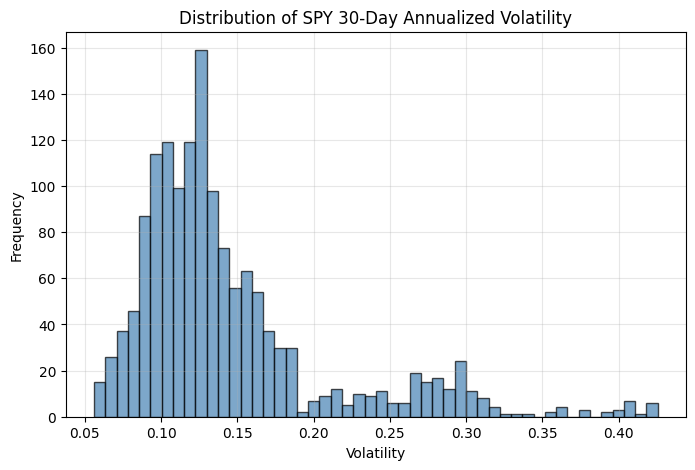

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
df = pd.read_csv("beta_project_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df[df["Symbol"] == "SPY"].sort_values("Date")

# Compute daily returns
df["Return"] = df["Close"].pct_change()

# Compute rolling volatility (30-day window)
df["Volatility"] = df["Return"].rolling(30).std() * np.sqrt(252)  # annualized

# Drop missing values
vol = df["Volatility"].dropna()

# Plot distribution
plt.figure(figsize=(8,5))
plt.hist(vol, bins=50, color="steelblue", edgecolor="black", alpha=0.7)
plt.title("Distribution of SPY 30-Day Annualized Volatility")
plt.xlabel("Volatility")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


Total path-level MSE (all horizons): 311.2340


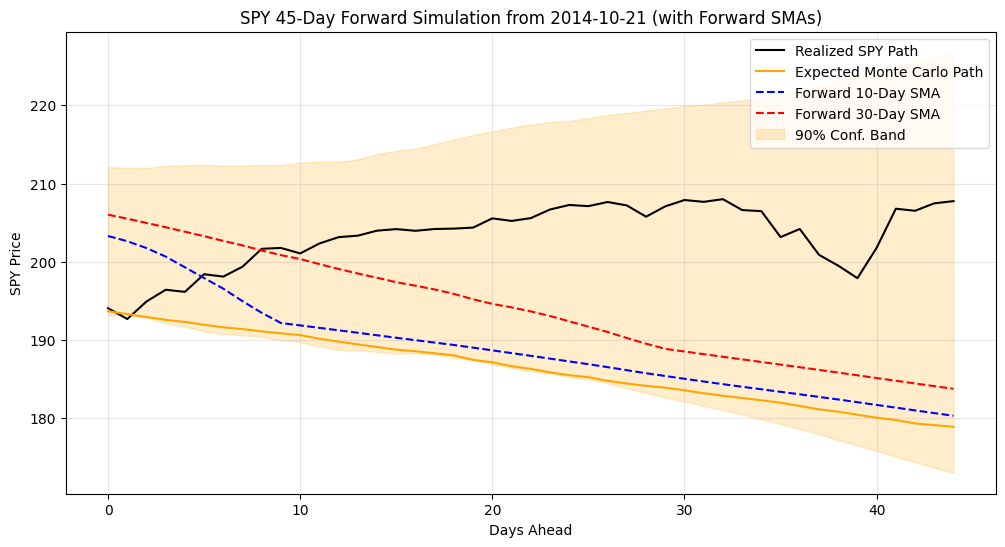

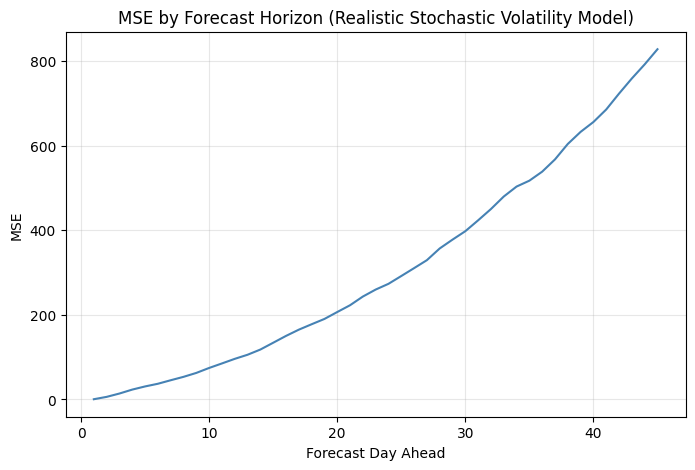

In [27]:
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow as tf

# ------------------ Deterministic setup ------------------
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["PYTHONHASHSEED"] = "0"
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# ------------------ Load SPY ------------------
df = pd.read_csv("beta_project_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df[df["Symbol"] == "SPY"].sort_values("Date").reset_index(drop=True)
df["LogReturn"] = np.log(df["Close"] / df["Close"].shift(1))
df = df.dropna().reset_index(drop=True)

# Historical SMAs
df["SMA_10"] = df["Close"].rolling(10).mean()
df["SMA_30"] = df["Close"].rolling(30).mean()

# ------------------ Parameters ------------------
lookback = 30
horizon = 45
n_paths = 500

# ------------------ Realistic stochastic volatility simulator ------------------
def simulate_spy_paths_realistic(S0, returns_hist, horizon=45, n_paths=500):
    """Monte Carlo simulator with AR(1) drift, EWMA volatility, adaptive vol-of-vol & leverage."""
    if len(returns_hist) < 2 or np.var(returns_hist[:-1]) == 0:
        phi = 0
    else:
        phi = np.cov(returns_hist[:-1], returns_hist[1:])[0, 1] / np.var(returns_hist[:-1])
    mu_t = phi * returns_hist[-1]

    # EWMA volatility
    lambda_ = 0.94
    weights = lambda_ ** np.arange(len(returns_hist) - 1, -1, -1)
    weights /= weights.sum()
    sigma_t = np.sqrt(np.sum(weights * returns_hist**2))
    var = sigma_t**2
    theta = np.mean(returns_hist**2)

    # Dynamic vol-of-vol and leverage
    kappa = 0.1
    xi = 0.25 * sigma_t * (1 + 2 * abs(mu_t))
    rho = -0.3 * (1 + np.sign(mu_t))

    log_S0 = np.log(S0)
    paths = np.zeros((n_paths, horizon))

    for p in range(n_paths):
        logS = log_S0
        v = var
        for t in range(horizon):
            z1, z2 = np.random.normal(), np.random.normal()
            z_vol = rho * z1 + np.sqrt(1 - rho**2) * z2
            v = abs(v + kappa * (theta - v) + xi * np.sqrt(abs(v)) * z_vol)
            sigma_t = np.sqrt(v)
            logS += (mu_t - 0.5 * sigma_t**2) + sigma_t * z1
            paths[p, t] = np.exp(logS)
    return paths

# ------------------ Rolling Monte Carlo Forecast ------------------
train_size = int(0.8 * len(df))
forecasts, reals, dates = [], [], []

for i in range(train_size, len(df) - horizon):
    past_returns = df["LogReturn"].iloc[i - lookback:i].values
    S0 = df["Close"].iloc[i]
    sim_paths = simulate_spy_paths_realistic(S0, past_returns, horizon=horizon, n_paths=n_paths)
    exp_path = sim_paths.mean(axis=0)
    real_path = df["Close"].iloc[i:i + horizon].values
    forecasts.append(exp_path)
    reals.append(real_path)
    dates.append(df["Date"].iloc[i])

forecasts, reals = np.array(forecasts), np.array(reals)
mse_total = mean_squared_error(reals.flatten(), forecasts.flatten())
mse_by_day = [mean_squared_error(reals[:, d], forecasts[:, d]) for d in range(horizon)]
print(f"Total path-level MSE (all horizons): {mse_total:.4f}")

# ------------------ Compute Forward SMAs ------------------
def forward_sma(path, window):
    sma_vals = []
    prices = list(df["Close"].iloc[-window:].values)  # last 'window' prices as seed
    for p in path:
        prices.append(p)
        sma_vals.append(np.mean(prices[-window:]))
    return np.array(sma_vals)

# Example forecast path
t_idx = 0
forecast_path = forecasts[t_idx]
real_path = reals[t_idx]

# Forward 10-day and 30-day SMAs based on expected forecast
sma10_fwd = forward_sma(forecast_path, 10)
sma30_fwd = forward_sma(forecast_path, 30)

# ------------------ Visualization ------------------
plt.figure(figsize=(12,6))
plt.plot(range(horizon), real_path, color="black", label="Realized SPY Path")
plt.plot(range(horizon), forecast_path, color="orange", label="Expected Monte Carlo Path")
plt.plot(range(horizon), sma10_fwd, color="blue", linestyle="--", label="Forward 10-Day SMA")
plt.plot(range(horizon), sma30_fwd, color="red", linestyle="--", label="Forward 30-Day SMA")

plt.fill_between(range(horizon),
                 np.percentile(forecasts, 5, axis=0),
                 np.percentile(forecasts, 95, axis=0),
                 color="orange", alpha=0.2, label="90% Conf. Band")

start_date = df["Date"].iloc[train_size + t_idx]
plt.title(f"SPY 45-Day Forward Simulation from {start_date.date()} (with Forward SMAs)")
plt.xlabel("Days Ahead")
plt.ylabel("SPY Price")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# MSE by forecast horizon
plt.figure(figsize=(8,5))
plt.plot(range(1, horizon + 1), mse_by_day, color="steelblue")
plt.title("MSE by Forecast Horizon (Realistic Stochastic Volatility Model)")
plt.xlabel("Forecast Day Ahead")
plt.ylabel("MSE")
plt.grid(alpha=0.3)
plt.show()


Monte Carlo Total Path-Level MSE: 311.234017


c:\Users\likapichu\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
LSTM Total Path-Level MSE:       0.004103

Average MSE Comparison:
Monte Carlo Model : 311.234017
LSTM Model        : 0.004103
Relative Improvement (LSTM vs MC): 100.00%


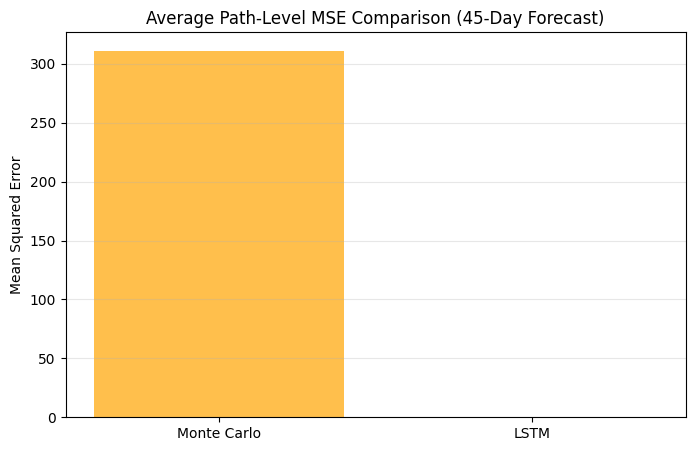

In [28]:
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ------------------ Deterministic setup ------------------
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["PYTHONHASHSEED"] = "0"
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# ------------------ Load SPY ------------------
df = pd.read_csv("beta_project_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df[df["Symbol"] == "SPY"].sort_values("Date").reset_index(drop=True)
df["LogReturn"] = np.log(df["Close"] / df["Close"].shift(1))
df = df.dropna().reset_index(drop=True)

# Historical SMAs
df["SMA_10"] = df["Close"].rolling(10).mean()
df["SMA_30"] = df["Close"].rolling(30).mean()

# ------------------ Parameters ------------------
lookback = 30
horizon = 45
n_paths = 500

# ------------------ Realistic stochastic volatility simulator ------------------
def simulate_spy_paths_realistic(S0, returns_hist, horizon=45, n_paths=500):
    """Monte Carlo simulator with AR(1) drift, EWMA volatility, adaptive vol-of-vol & leverage."""
    if len(returns_hist) < 2 or np.var(returns_hist[:-1]) == 0:
        phi = 0
    else:
        phi = np.cov(returns_hist[:-1], returns_hist[1:])[0, 1] / np.var(returns_hist[:-1])
    mu_t = phi * returns_hist[-1]

    # EWMA volatility
    lambda_ = 0.94
    weights = lambda_ ** np.arange(len(returns_hist) - 1, -1, -1)
    weights /= weights.sum()
    sigma_t = np.sqrt(np.sum(weights * returns_hist**2))
    var = sigma_t**2
    theta = np.mean(returns_hist**2)

    # Dynamic vol-of-vol and leverage
    kappa = 0.1
    xi = 0.25 * sigma_t * (1 + 2 * abs(mu_t))
    rho = -0.3 * (1 + np.sign(mu_t))

    log_S0 = np.log(S0)
    paths = np.zeros((n_paths, horizon))

    for p in range(n_paths):
        logS = log_S0
        v = var
        for t in range(horizon):
            z1, z2 = np.random.normal(), np.random.normal()
            z_vol = rho * z1 + np.sqrt(1 - rho**2) * z2
            v = abs(v + kappa * (theta - v) + xi * np.sqrt(abs(v)) * z_vol)
            sigma_t = np.sqrt(v)
            logS += (mu_t - 0.5 * sigma_t**2) + sigma_t * z1
            paths[p, t] = np.exp(logS)
    return paths

# ------------------ Rolling Monte Carlo Forecast ------------------
train_size = int(0.8 * len(df))
forecasts_mc, reals, dates = [], [], []

for i in range(train_size, len(df) - horizon):
    past_returns = df["LogReturn"].iloc[i - lookback:i].values
    S0 = df["Close"].iloc[i]
    sim_paths = simulate_spy_paths_realistic(S0, past_returns, horizon=horizon, n_paths=n_paths)
    exp_path = sim_paths.mean(axis=0)
    real_path = df["Close"].iloc[i:i + horizon].values
    forecasts_mc.append(exp_path)
    reals.append(real_path)
    dates.append(df["Date"].iloc[i])

forecasts_mc, reals = np.array(forecasts_mc), np.array(reals)
mse_mc = mean_squared_error(reals.flatten(), forecasts_mc.flatten())
print(f"Monte Carlo Total Path-Level MSE: {mse_mc:.6f}")

# ------------------ LSTM Forecast ------------------
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(df[["Close"]])
X, y = [], []

for i in range(lookback, len(scaled_close) - horizon):
    X.append(scaled_close[i - lookback:i, 0])
    y.append(scaled_close[i:i + horizon, 0])  # predict all 45 days ahead

X, y = np.array(X), np.array(y)
X = X.reshape(X.shape[0], X.shape[1], 1)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential([
    LSTM(64, input_shape=(lookback, 1), return_sequences=False),
    Dropout(0.3),
    Dense(horizon)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="mse")
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=50, batch_size=32, verbose=0, shuffle=False, callbacks=[es])

preds_lstm = model.predict(X_test)
mse_lstm = mean_squared_error(y_test.flatten(), preds_lstm.flatten())
print(f"LSTM Total Path-Level MSE:       {mse_lstm:.6f}")

# ------------------ Comparison Summary ------------------
print(f"\nAverage MSE Comparison:")
print(f"Monte Carlo Model : {mse_mc:.6f}")
print(f"LSTM Model        : {mse_lstm:.6f}")
improvement = ((mse_mc - mse_lstm) / mse_mc) * 100
print(f"Relative Improvement (LSTM vs MC): {improvement:.2f}%")

# ------------------ Visualization ------------------
plt.figure(figsize=(8,5))
plt.bar(["Monte Carlo", "LSTM"], [mse_mc, mse_lstm],
        color=["orange", "steelblue"], alpha=0.7)
plt.title("Average Path-Level MSE Comparison (45-Day Forecast)")
plt.ylabel("Mean Squared Error")
plt.grid(alpha=0.3, axis="y")
plt.show()


    Stock  Correlation  Covariance       MSE  Wasserstein_Distance  \
65    IWB     0.993533    0.000082  0.000001              0.000211   
67    IWF     0.980508    0.000082  0.000003              0.000327   
119   VTV     0.982040    0.000080  0.000003              0.000430   
66    IWD     0.979667    0.000081  0.000004              0.000535   
34    DIA     0.976898    0.000080  0.000004              0.000490   
93    QQQ     0.940614    0.000090  0.000010              0.000487   
70    IWR     0.970820    0.000079  0.000006              0.000932   
131   XLK     0.933277    0.000088  0.000011              0.000497   
130   XLI     0.932556    0.000084  0.000011              0.000782   
134   XLY     0.921431    0.000081  0.000013              0.000773   
80    MDY     0.942949    0.000078  0.000011              0.001182   
62    IJH     0.939281    0.000077  0.000012              0.001200   
132   XLP     0.857648    0.000063  0.000025              0.000717   
129   XLF     0.9277

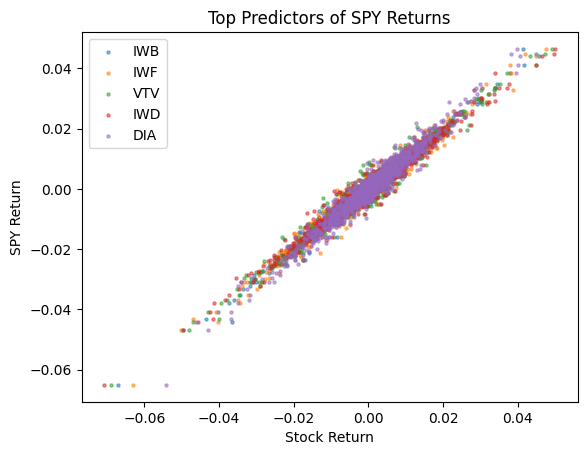

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance

# ---------------------- LOAD AND CLEAN ----------------------
df = pd.read_csv("beta_project_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Date", "Symbol"])

# Pivot to wide format
prices = df.pivot(index="Date", columns="Symbol", values="Close").dropna(axis=1, how="any")

# Compute daily returns
returns = prices.pct_change().dropna()

# Separate SPY and other stocks
spy = returns["SPY"]
others = returns.drop(columns=["SPY"])

# ---------------------- FUNCTION: TRAIN REGRESSION ----------------------
def evaluate_predictor(stock_name, stock_series, target_series):
    # Align both series
    aligned = pd.concat([stock_series, target_series], axis=1, join="inner").dropna()
    X = aligned.iloc[:, 0].values.reshape(-1, 1)
    y = aligned.iloc[:, 1].values

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

    # Fit regression
    model = LinearRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Error metrics
    mse = mean_squared_error(y_test, y_pred)
    corr = np.corrcoef(X_test.flatten(), y_test)[0, 1]
    cov = np.cov(X_test.flatten(), y_test)[0, 1]
    dist = wasserstein_distance(y_test, y_pred)  # measures distributional similarity

    return {
        "Stock": stock_name,
        "Correlation": corr,
        "Covariance": cov,
        "MSE": mse,
        "Wasserstein_Distance": dist,
        "Regression_Coeff": model.coef_[0]
    }

# ---------------------- RUN FOR ALL STOCKS ----------------------
results = []
for stock in others.columns:
    stats = evaluate_predictor(stock, others[stock], spy)
    results.append(stats)

results_df = pd.DataFrame(results)

# ---------------------- RANK BY BEST PREDICTIVE STRENGTH ----------------------
# Lower MSE & Wasserstein are better, higher correlation is better
results_df["Score"] = (
    results_df["Correlation"].abs() / (results_df["MSE"] * results_df["Wasserstein_Distance"])
)

best_predictors = results_df.sort_values("Score", ascending=False)

# ---------------------- DISPLAY RESULTS ----------------------
pd.set_option("display.max_rows", None)
print(best_predictors[["Stock", "Correlation", "Covariance", "MSE", "Wasserstein_Distance", "Regression_Coeff", "Score"]].head(20))

# Optional: visualize top correlations
import matplotlib.pyplot as plt

top_stocks = best_predictors.head(5)["Stock"].tolist()
for s in top_stocks:
    plt.scatter(others[s], spy, s=5, alpha=0.5, label=s)
plt.legend()
plt.title("Top Predictors of SPY Returns")
plt.xlabel("Stock Return")
plt.ylabel("SPY Return")
plt.show()


    Stock  Correlation  Covariance       MSE  Wasserstein_Distance  \
65    IWB     0.993533    0.000082  0.000001              0.000211   
67    IWF     0.980508    0.000082  0.000003              0.000327   
119   VTV     0.982040    0.000080  0.000003              0.000430   
66    IWD     0.979667    0.000081  0.000004              0.000535   
34    DIA     0.976898    0.000080  0.000004              0.000490   
93    QQQ     0.940614    0.000090  0.000010              0.000487   
70    IWR     0.970820    0.000079  0.000006              0.000932   
131   XLK     0.933277    0.000088  0.000011              0.000497   
130   XLI     0.932556    0.000084  0.000011              0.000782   
134   XLY     0.921431    0.000081  0.000013              0.000773   
80    MDY     0.942949    0.000078  0.000011              0.001182   
62    IJH     0.939281    0.000077  0.000012              0.001200   
132   XLP     0.857648    0.000063  0.000025              0.000717   
129   XLF     0.9277

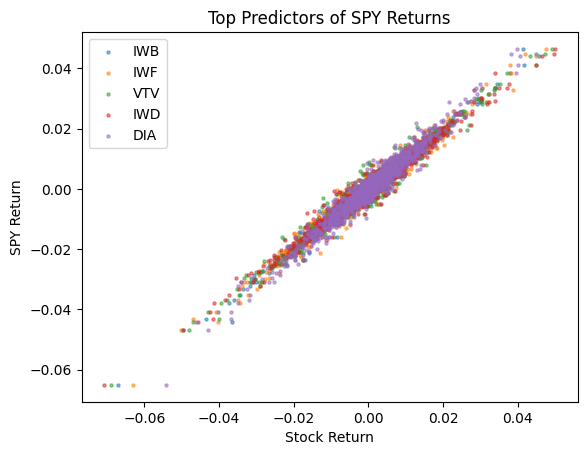

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance

# ---------------------- LOAD AND CLEAN ----------------------
df = pd.read_csv("beta_project_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Date", "Symbol"])

# Pivot to wide format
prices = df.pivot(index="Date", columns="Symbol", values="Close").dropna(axis=1, how="any")

# Compute daily returns
returns = prices.pct_change().dropna()

# Separate SPY and other stocks
spy = returns["SPY"]
others = returns.drop(columns=["SPY"])

# ---------------------- FUNCTION: TRAIN REGRESSION ----------------------
def evaluate_predictor(stock_name, stock_series, target_series):
    # Align both series
    aligned = pd.concat([stock_series, target_series], axis=1, join="inner").dropna()
    X = aligned.iloc[:, 0].values.reshape(-1, 1)
    y = aligned.iloc[:, 1].values

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

    # Fit regression
    model = LinearRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Error metrics
    mse = mean_squared_error(y_test, y_pred)
    corr = np.corrcoef(X_test.flatten(), y_test)[0, 1]
    cov = np.cov(X_test.flatten(), y_test)[0, 1]
    dist = wasserstein_distance(y_test, y_pred)  # measures distributional similarity

    return {
        "Stock": stock_name,
        "Correlation": corr,
        "Covariance": cov,
        "MSE": mse,
        "Wasserstein_Distance": dist,
        "Regression_Coeff": model.coef_[0]
    }

# ---------------------- RUN FOR ALL STOCKS ----------------------
results = []
for stock in others.columns:
    stats = evaluate_predictor(stock, others[stock], spy)
    results.append(stats)

results_df = pd.DataFrame(results)

# ---------------------- RANK BY BEST PREDICTIVE STRENGTH ----------------------
# Lower MSE & Wasserstein are better, higher correlation is better
results_df["Score"] = (
    results_df["Correlation"].abs() / (results_df["MSE"] * results_df["Wasserstein_Distance"])
)

best_predictors = results_df.sort_values("Score", ascending=False)

# ---------------------- DISPLAY RESULTS ----------------------
pd.set_option("display.max_rows", None)
print(best_predictors[["Stock", "Correlation", "Covariance", "MSE", "Wasserstein_Distance", "Regression_Coeff", "Score"]].head(20))

# Optional: visualize top correlations
import matplotlib.pyplot as plt

top_stocks = best_predictors.head(5)["Stock"].tolist()
for s in top_stocks:
    plt.scatter(others[s], spy, s=5, alpha=0.5, label=s)
plt.legend()
plt.title("Top Predictors of SPY Returns")
plt.xlabel("Stock Return")
plt.ylabel("SPY Return")
plt.show()


In [31]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# -------------------- Load data --------------------
df = pd.read_csv("beta_project_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Symbol", "Date"]).reset_index(drop=True)

# -------------------- Returns ----------------------
df["Return"] = df.groupby("Symbol")["Close"].pct_change()

# -------------------- SPY returns ------------------
spy = df[df["Symbol"] == "SPY"][["Date", "Return"]].rename(columns={"Return": "SPY_Return"})
data = df.merge(spy, on="Date", how="left")

# Keep only dates where SPY exists
data = data.dropna(subset=["SPY_Return"]).reset_index(drop=True)

# -------------------- Feature engineering (rolling past, no leakage) --------------------
def add_past_features(g):
    g = g.copy()
    # Momentum (mean returns)
    g["ret_mean_5"]  = g["Return"].rolling(5,  min_periods=5).mean()
    g["ret_mean_10"] = g["Return"].rolling(10, min_periods=10).mean()
    g["ret_mean_20"] = g["Return"].rolling(20, min_periods=20).mean()

    # Volatility (std of returns)
    g["vol_10"] = g["Return"].rolling(10, min_periods=10).std()
    g["vol_20"] = g["Return"].rolling(20, min_periods=20).std()
    g["vol_45"] = g["Return"].rolling(45, min_periods=45).std()

    # Correlation with SPY (past)
    g["corr_45"] = g["Return"].rolling(45, min_periods=45).corr(g["SPY_Return"])

    # Rolling beta (past) = cov/var using trailing 45 days
    cov_45 = g["Return"].rolling(45, min_periods=45).cov(g["SPY_Return"])
    var_spy_45 = g["SPY_Return"].rolling(45, min_periods=45).var()
    g["beta_past_45"] = cov_45 / var_spy_45

    # Price relative to moving averages
    g["price_ma_10"] = g["Close"] / g["Close"].rolling(10, min_periods=10).mean() - 1
    g["price_ma_30"] = g["Close"] / g["Close"].rolling(30, min_periods=30).mean() - 1
    g["price_ma_60"] = g["Close"] / g["Close"].rolling(60, min_periods=60).mean() - 1

    # Volume features
    g["vol_chg_5"]  = g["Volume"].pct_change().rolling(5,  min_periods=5).mean()
    g["vol_chg_20"] = g["Volume"].pct_change().rolling(20, min_periods=20).mean()

    return g

data = data.groupby("Symbol", group_keys=False).apply(add_past_features)

# SPY rolling stats as global features (past)
data["spy_vol_10"] = data["SPY_Return"].rolling(10, min_periods=10).std()
data["spy_vol_20"] = data["SPY_Return"].rolling(20, min_periods=20).std()
data["spy_vol_45"] = data["SPY_Return"].rolling(45, min_periods=45).std()

# -------------------- Target engineering: FUTURE 45-day beta --------------------
# Future window t+1..t+45 -> shift(-1) then rolling(45)
def add_future_beta(g):
    g = g.copy()
    fut_cov = g["Return"].shift(-1).rolling(45, min_periods=45).cov(g["SPY_Return"].shift(-1))
    fut_var = g["SPY_Return"].shift(-1).rolling(45, min_periods=45).var()
    g["beta_future_45"] = fut_cov / fut_var
    return g

data = data.groupby("Symbol", group_keys=False).apply(add_future_beta)

# -------------------- Cleanup --------------------
feature_cols = [
    "ret_mean_5","ret_mean_10","ret_mean_20",
    "vol_10","vol_20","vol_45",
    "corr_45","beta_past_45",
    "price_ma_10","price_ma_30","price_ma_60",
    "vol_chg_5","vol_chg_20",
    "spy_vol_10","spy_vol_20","spy_vol_45"
]

# Drop rows with insufficient history or insufficient future horizon
data_model = data.dropna(subset=feature_cols + ["beta_future_45"]).copy()

# Exclude SPY from training target (optional; comment out to include)
data_model = data_model[data_model["Symbol"] != "SPY"].reset_index(drop=True)

# -------------------- Train / Test split by date (no leakage) --------------------
# Use last 20% of dates as test
unique_dates = np.sort(data_model["Date"].unique())
cutoff_idx = int(0.8 * len(unique_dates))
cutoff_date = unique_dates[cutoff_idx]

train = data_model[data_model["Date"] <= cutoff_date].copy()
test  = data_model[data_model["Date"] >  cutoff_date].copy()

X_train, y_train = train[feature_cols].values, train["beta_future_45"].values
X_test,  y_test  = test[feature_cols].values,  test["beta_future_45"].values

# -------------------- Model --------------------
model = Pipeline([
    ("scaler", StandardScaler()),
    ("gbr", GradientBoostingRegressor(random_state=42, n_estimators=500, max_depth=3, learning_rate=0.03, subsample=0.8))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# -------------------- Statistics --------------------
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print("==== Overall Test Statistics (Future 45-Day Beta) ====")
print(f"Samples (train/test): {len(train)} / {len(test)}")
print(f"Date cutoff: {str(cutoff_date)[:10]}")
print(f"MSE : {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE : {mae:.6f}")
print(f"R^2 : {r2:.6f}")

# Per-symbol MSE
test_preds = test.copy()
test_preds["y_pred"] = y_pred
sym_mse = test_preds.groupby("Symbol").apply(lambda x: mean_squared_error(x["beta_future_45"], x["y_pred"]))
sym_mse = sym_mse.sort_values()

print("\n==== Per-Symbol MSE (Top 15 best) ====")
print(sym_mse.head(15))

print("\n==== Per-Symbol MSE (Top 15 worst) ====")
print(sym_mse.tail(15))

# Feature importance (from trained tree ensemble)
gbr = model.named_steps["gbr"]
importances = gbr.feature_importances_
fi = pd.Series(importances, index=feature_cols).sort_values(ascending=False)

print("\n==== Feature Importances ====")
print(fi)

# Time-series cross-validation (optional summary)
tscv = TimeSeriesSplit(n_splits=3)
cv_scores = []
for tr_idx, val_idx in tscv.split(train[feature_cols].values):
    X_tr, X_val = X_train[tr_idx], X_train[val_idx]
    y_tr, y_val = y_train[tr_idx], y_train[val_idx]
    mdl = Pipeline([
        ("scaler", StandardScaler()),
        ("gbr", GradientBoostingRegressor(random_state=42, n_estimators=500, max_depth=3, learning_rate=0.03, subsample=0.8))
    ])
    mdl.fit(X_tr, y_tr)
    cv_scores.append(mean_squared_error(y_val, mdl.predict(X_val)))

print("\n==== TimeSeriesSplit CV MSE (3 folds) ====")
print(cv_scores)
print(f"CV MSE mean: {np.mean(cv_scores):.6f}, std: {np.std(cv_scores):.6f}")


C:\Users\likapichu\AppData\Local\Temp\ipykernel_31012\2446435052.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby("Symbol", group_keys=False).apply(add_past_features)
C:\Users\likapichu\AppData\Local\Temp\ipykernel_31012\2446435052.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby("Symbol", group_keys=False).apply(add_future_beta)


==== Overall Test Statistics (Future 45-Day Beta) ====
Samples (train/test): 219989 / 57667
Date cutoff: 2014-11-05
MSE : 0.014382
RMSE: 0.119924
MAE : 0.034190
R^2 : 0.985466

==== Per-Symbol MSE (Top 15 best) ====
Symbol
IVV    0.000032
IWB    0.000034
VTI    0.000047
VOO    0.000050
IWD    0.000056
VTV    0.000061
IWF    0.000067
DIA    0.000076
IWR    0.000116
SHY    0.000175
IJH    0.000188
MDY    0.000198
XLI    0.000234
XLF    0.000235
XLY    0.000247
dtype: float64

==== Per-Symbol MSE (Top 15 worst) ====
Symbol
USO       0.009673
WMB       0.010037
SBUX      0.010152
MU        0.010888
NFLX      0.011467
BHC       0.013076
TWTR      0.013711
GDX       0.014025
VXX       0.021007
CMRX      0.021401
XIV       0.022846
WW        0.023729
V         0.025043
DWTI.F    0.099136
UVXY      2.105017
dtype: float64

==== Feature Importances ====
beta_past_45    0.979489
corr_45         0.005390
price_ma_60     0.004194
spy_vol_45      0.002818
vol_10          0.002718
vol_45          0.

C:\Users\likapichu\AppData\Local\Temp\ipykernel_31012\2446435052.py:128: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sym_mse = test_preds.groupby("Symbol").apply(lambda x: mean_squared_error(x["beta_future_45"], x["y_pred"]))



==== TimeSeriesSplit CV MSE (3 folds) ====
[0.04176625021186501, 0.5507943205461797, 0.22465569132726707]
CV MSE mean: 0.272405, std: 0.210535


==== Overall Test Statistics (Future 45-Day Beta) ====
Samples (train/test): 219989 / 57667
Date cutoff: 2014-11-05
MSE : 0.014382
RMSE: 0.119924
MAE : 0.034190
R^2 : 0.985466

==== Per-Symbol MSE (Top 15 best) ====
Symbol
IVV    0.000032
IWB    0.000034
VTI    0.000047
VOO    0.000050
IWD    0.000056
VTV    0.000061
IWF    0.000067
DIA    0.000076
IWR    0.000116
SHY    0.000175
IJH    0.000188
MDY    0.000198
XLI    0.000234
XLF    0.000235
XLY    0.000247
dtype: float64

==== Per-Symbol MSE (Top 15 worst) ====
Symbol
USO       0.009673
WMB       0.010037
SBUX      0.010152
MU        0.010888
NFLX      0.011467
BHC       0.013076
TWTR      0.013711
GDX       0.014025
VXX       0.021007
CMRX      0.021401
XIV       0.022846
WW        0.023729
V         0.025043
DWTI.F    0.099136
UVXY      2.105017
dtype: float64

==== Feature Importances ====
beta_past_45    0.979489
corr_45         0.005390
price_ma_60     0.004194
spy_vol_45      0.002818
vol_10          0.002718
vol_45          0.001390
ret_mean_5      0.000928
vol_20          0.000766
ret_mean_10     0.000508
vol_chg_5       0.000468
vol_chg_20      0.000448
price_ma_30     0.000328
spy_vol_20      0.000224
spy_vol_10      0.000189
price_ma_10     0.000090
ret_mean_20     0.000055
dtype: float64

==== TimeSeriesSplit CV MSE (3 folds) ====
[0.04176625021186501, 0.5507943205461797, 0.22465569132726707]
CV MSE mean: 0.272405, std: 0.210535

C:\Users\likapichu\AppData\Local\Temp\ipykernel_31012\513948684.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged = merged.groupby("Symbol").apply(add_features, window).reset_index(drop=True)
c:\Users\likapichu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1701/1701 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step
Direct Beta MSE: 0.03592849995124069


c:\Users\likapichu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1701/1701 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step
1701/1701 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step
Split Cov/Var Derived Beta MSE: 3065519.666575436

--- Model Comparison ---
Direct Beta model MSE:      0.03592849995124069
Split Cov/Var model MSE:    3065519.666575436


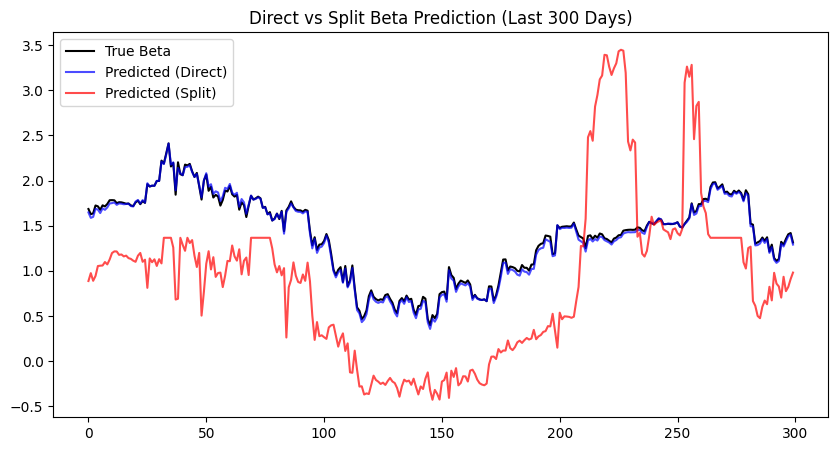

In [33]:
import os, random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ------------------ Deterministic setup ------------------
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["PYTHONHASHSEED"] = "0"
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# ------------------ Load Data ------------------
df = pd.read_csv("beta_project_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Symbol", "Date"]).reset_index(drop=True)

# ------------------ Compute daily log returns ------------------
df["LogReturn"] = np.log(df["Close"] / df["Close"].shift(1))
df = df.dropna().reset_index(drop=True)

# ------------------ Separate SPY as market index ------------------
spy = df[df["Symbol"] == "SPY"].copy()
spy = spy[["Date", "LogReturn"]].rename(columns={"LogReturn": "SPY_LogReturn"})

# ------------------ Merge market return with each stock ------------------
merged = df.merge(spy, on="Date", how="inner")
merged = merged[merged["Symbol"] != "SPY"].reset_index(drop=True)

# ------------------ Rolling covariance, variance, and Beta ------------------
window = 45
merged["Cov"] = merged.groupby("Symbol")[["LogReturn", "SPY_LogReturn"]].apply(
    lambda x: x["LogReturn"].rolling(window).cov(x["SPY_LogReturn"])
).reset_index(level=0, drop=True)
merged["Var_SPY"] = merged["SPY_LogReturn"].rolling(window).var()
merged["Beta"] = merged["Cov"] / merged["Var_SPY"]
merged = merged.dropna().reset_index(drop=True)

# ------------------ Feature Engineering ------------------
def add_features(df, window=45):
    df["Stock_Vol"] = df["LogReturn"].rolling(window).std()
    df["SPY_Vol"] = df["SPY_LogReturn"].rolling(window).std()
    df["Rolling_Corr"] = df["Cov"] / (df["Stock_Vol"] * df["SPY_Vol"])
    df["Momentum"] = df["Close"].pct_change(window)
    df["Vol_Ratio"] = df["Stock_Vol"] / df["SPY_Vol"]
    df["Lagged_Beta"] = df["Beta"].shift(1)
    return df

merged = merged.groupby("Symbol").apply(add_features, window).reset_index(drop=True)
merged = merged.dropna().reset_index(drop=True)

# ------------------ Features and Targets ------------------
features = ["Rolling_Corr", "Stock_Vol", "SPY_Vol", "Momentum", "Vol_Ratio", "Lagged_Beta"]
X = merged[features].values
y_beta = merged["Beta"].values
y_cov = merged["Cov"].values
y_var = merged["Var_SPY"].values

# ------------------ Train/Test Split ------------------
X_train, X_test, y_beta_train, y_beta_test = train_test_split(X, y_beta, test_size=0.2, shuffle=False)
_, _, y_cov_train, y_cov_test = train_test_split(X, y_cov, test_size=0.2, shuffle=False)
_, _, y_var_train, y_var_test = train_test_split(X, y_var, test_size=0.2, shuffle=False)

# ------------------ Scaling ------------------
scaler = StandardScaler().fit(X_train)
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

# ------------------ Direct Beta Model ------------------
direct_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
direct_model.compile(optimizer='adam', loss='mse')
direct_model.fit(X_train, y_beta_train, epochs=20, batch_size=128, verbose=0)

y_pred_direct = direct_model.predict(X_test).flatten()
mse_direct = mean_squared_error(y_beta_test, y_pred_direct)
print("Direct Beta MSE:", mse_direct)

# ------------------ Covariance Model ------------------
cov_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
cov_model.compile(optimizer='adam', loss='mse')
cov_model.fit(X_train, y_cov_train, epochs=20, batch_size=128, verbose=0)

# ------------------ Variance Model ------------------
var_model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
var_model.compile(optimizer='adam', loss='mse')
var_model.fit(X_train, y_var_train, epochs=20, batch_size=128, verbose=0)

# ------------------ Compute Derived Beta ------------------
cov_pred = cov_model.predict(X_test).flatten()
var_pred = np.maximum(var_model.predict(X_test).flatten(), 1e-8)
beta_pred_split = cov_pred / var_pred
mse_split = mean_squared_error(y_beta_test, beta_pred_split)
print("Split Cov/Var Derived Beta MSE:", mse_split)

# ------------------ Comparison ------------------
print("\n--- Model Comparison ---")
print("Direct Beta model MSE:     ", mse_direct)
print("Split Cov/Var model MSE:   ", mse_split)

# ------------------ Visualization ------------------
plt.figure(figsize=(10,5))
plt.plot(y_beta_test[-300:], label="True Beta", color="black")
plt.plot(y_pred_direct[-300:], label="Predicted (Direct)", alpha=0.7, color="blue")
plt.plot(beta_pred_split[-300:], label="Predicted (Split)", alpha=0.7, color="red")
plt.legend()
plt.title("Direct vs Split Beta Prediction (Last 300 Days)")
plt.show()


C:\Users\likapichu\AppData\Local\Temp\ipykernel_31012\699994224.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged = merged.groupby("Symbol").apply(make_features, window).reset_index(drop=True)
c:\Users\likapichu\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
AAPL Beta Prediction MSE: 0.014301788172825828


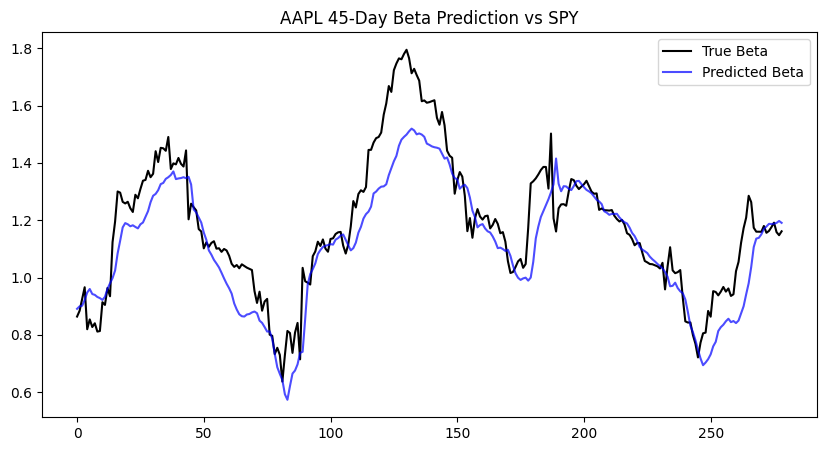

In [34]:
import os, random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ------------------ Deterministic setup ------------------
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["PYTHONHASHSEED"] = "0"
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# ------------------ Load Data ------------------
df = pd.read_csv("beta_project_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Symbol", "Date"]).reset_index(drop=True)

# ------------------ Compute daily log returns ------------------
df["LogReturn"] = np.log(df["Close"] / df["Close"].shift(1))
df = df.dropna().reset_index(drop=True)

# ------------------ SPY as market reference ------------------
spy = df[df["Symbol"] == "SPY"].copy()
spy = spy[["Date", "LogReturn"]].rename(columns={"LogReturn": "SPY_LogReturn"})

# ------------------ Merge SPY returns into each stock ------------------
merged = df.merge(spy, on="Date", how="inner")
merged = merged[merged["Symbol"] != "SPY"].reset_index(drop=True)

# ------------------ Rolling Beta computation ------------------
window = 45
merged["Cov"] = merged.groupby("Symbol")[["LogReturn", "SPY_LogReturn"]].apply(
    lambda x: x["LogReturn"].rolling(window).cov(x["SPY_LogReturn"])
).reset_index(level=0, drop=True)
merged["Var_SPY"] = merged["SPY_LogReturn"].rolling(window).var()
merged["Beta"] = merged["Cov"] / merged["Var_SPY"]
merged = merged.dropna().reset_index(drop=True)

# ------------------ Feature Engineering ------------------
def make_features(df, window=45):
    df["Stock_Vol"] = df["LogReturn"].rolling(window).std()
    df["SPY_Vol"] = df["SPY_LogReturn"].rolling(window).std()
    df["Rolling_Corr"] = df["Cov"] / (df["Stock_Vol"] * df["SPY_Vol"])
    df["Momentum"] = df["Close"].pct_change(window)
    df["Vol_Ratio"] = df["Stock_Vol"] / df["SPY_Vol"]
    df["Lagged_Beta"] = df["Beta"].shift(1)
    return df

merged = merged.groupby("Symbol").apply(make_features, window).reset_index(drop=True)
merged = merged.dropna().reset_index(drop=True)

# ------------------ Select one stock for training (example: AAPL) ------------------
stock = "AAPL"
stock_df = merged[merged["Symbol"] == stock].copy()

features = ["Rolling_Corr", "Stock_Vol", "SPY_Vol", "Momentum", "Vol_Ratio", "Lagged_Beta"]
X = stock_df[features].values
y = stock_df["Beta"].values

# ------------------ Sequence preparation for LSTM ------------------
lookback = 30  # past 30 days to predict next beta
X_seq, y_seq = [], []
for i in range(lookback, len(X)):
    X_seq.append(X[i - lookback:i])
    y_seq.append(y[i])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)

split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# ------------------ Normalize features ------------------
scaler = StandardScaler()
nsamp, nsteps, nfeat = X_train.shape
X_train = X_train.reshape(-1, nfeat)
X_test = X_test.reshape(-1, nfeat)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = X_train.reshape(nsamp, nsteps, nfeat)
X_test = X_test.reshape(X_test.shape[0]//nsteps, nsteps, nfeat)

# ------------------ LSTM model ------------------
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(lookback, len(features)), return_sequences=False),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

# ------------------ Predictions ------------------
y_pred = model.predict(X_test).flatten()
mse = mean_squared_error(y_test, y_pred)
print(f"{stock} Beta Prediction MSE:", mse)

# ------------------ Visualization ------------------
plt.figure(figsize=(10,5))
plt.plot(y_test[-300:], label="True Beta", color='black')
plt.plot(y_pred[-300:], label="Predicted Beta", color='blue', alpha=0.7)
plt.title(f"{stock} 45-Day Beta Prediction vs SPY")
plt.legend()
plt.show()

# ------------------ Generalization ------------------
# To extend this across all symbols:
# loop through merged['Symbol'].unique() and repeat the same block,
# storing each stock’s model MSE or predicted Beta path.


C:\Users\likapichu\AppData\Local\Temp\ipykernel_31012\2820100356.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged["Rolling_Corr"] = merged.groupby("Symbol").apply(
C:\Users\likapichu\AppData\Local\Temp\ipykernel_31012\2820100356.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged = merged.groupby("Symbol").apply(make_features, window).reset_index(drop=True)
c:\Users\likapichu\anaconda3\Li

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
AAPL Beta Prediction MSE: 0.011581755558832972


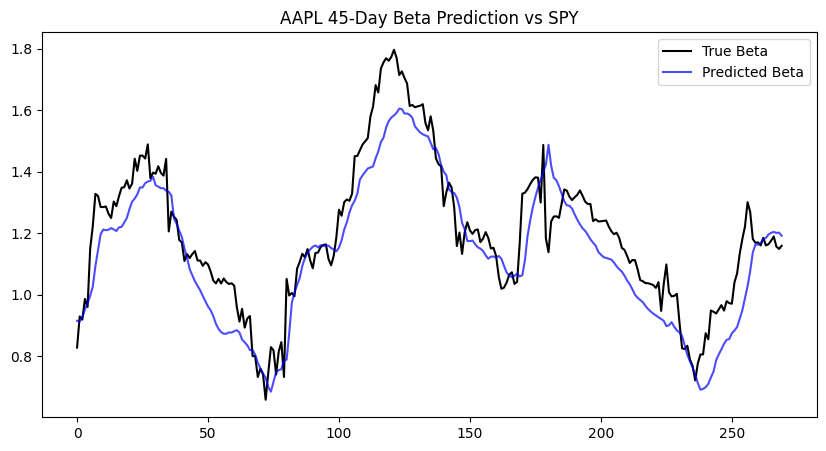

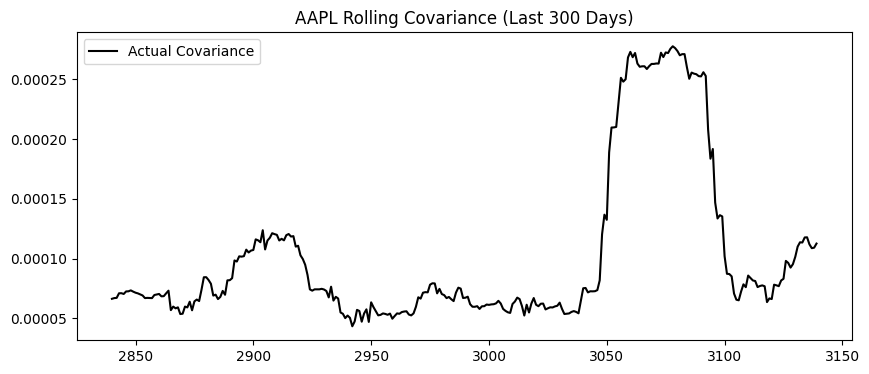

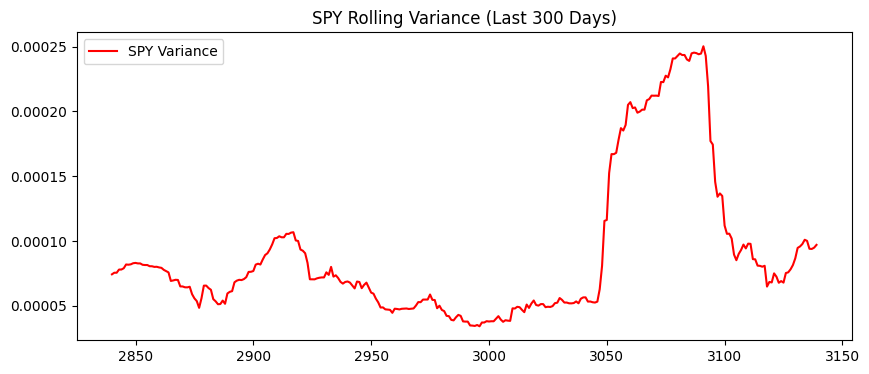

In [ ]:
import os, random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ------------------ Deterministic setup ------------------
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["PYTHONHASHSEED"] = "0"
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# ------------------ Load Data ------------------
df = pd.read_csv("beta_project_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Symbol", "Date"]).reset_index(drop=True)

# ------------------ Compute daily log returns ------------------
df["LogReturn"] = np.log(df["Close"] / df["Close"].shift(1))
df = df.dropna().reset_index(drop=True)

# ------------------ Stable SPY reference ------------------
window = 45
spy = df[df["Symbol"] == "SPY"].copy()
spy["SPY_Var"] = spy["LogReturn"].rolling(window).var()
spy["SPY_Vol"] = spy["LogReturn"].rolling(window).std()
spy["SPY_Mean"] = spy["LogReturn"].rolling(window).mean()
spy = spy[["Date", "SPY_Var", "SPY_Vol", "SPY_Mean", "LogReturn"]].rename(columns={"LogReturn": "SPY_LogReturn"})

# ------------------ Merge SPY metrics into each stock ------------------
merged = df.merge(spy, on="Date", how="inner")
merged = merged[merged["Symbol"] != "SPY"].reset_index(drop=True)

# ------------------ Compute stable covariance, variance, and beta ------------------
merged["Stock_Vol"] = merged.groupby("Symbol")["LogReturn"].transform(lambda x: x.rolling(window).std())
merged["Stock_Mean"] = merged.groupby("Symbol")["LogReturn"].transform(lambda x: x.rolling(window).mean())
merged["LogReturn_demean"] = merged["LogReturn"] - merged["Stock_Mean"]
merged["SPY_demean"] = merged["SPY_LogReturn"] - merged["SPY_Mean"]

merged["Rolling_Corr"] = merged.groupby("Symbol").apply(
    lambda g: g["LogReturn_demean"].rolling(window).corr(g["SPY_demean"])
).reset_index(level=0, drop=True)

merged["Cov"] = merged["Rolling_Corr"] * merged["Stock_Vol"] * merged["SPY_Vol"]
merged["Var_SPY"] = merged["SPY_Var"]
merged["Beta"] = merged["Cov"] / merged["Var_SPY"]
merged = merged.dropna().reset_index(drop=True)

# ------------------ Feature Engineering ------------------
def make_features(df, window=45):
    df["Momentum"] = df["Close"].pct_change(window)
    df["Vol_Ratio"] = df["Stock_Vol"] / df["SPY_Vol"]
    df["Lagged_Beta"] = df["Beta"].shift(1)
    return df

merged = merged.groupby("Symbol").apply(make_features, window).reset_index(drop=True)
merged = merged.dropna().reset_index(drop=True)

# ------------------ Select one stock (example: AAPL) ------------------
stock = "AAPL"
stock_df = merged[merged["Symbol"] == stock].copy()

features = ["Rolling_Corr", "Stock_Vol", "SPY_Vol", "Momentum", "Vol_Ratio", "Lagged_Beta"]
X = stock_df[features].values
y = stock_df["Beta"].values

# ------------------ Prepare sequences for LSTM ------------------
lookback = 30
X_seq, y_seq = [], []
for i in range(lookback, len(X)):
    X_seq.append(X[i - lookback:i])
    y_seq.append(y[i])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)

split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# ------------------ Normalize features ------------------
scaler = StandardScaler()
nsamp, nsteps, nfeat = X_train.shape
X_train = X_train.reshape(-1, nfeat)
X_test = X_test.reshape(-1, nfeat)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = X_train.reshape(nsamp, nsteps, nfeat)
X_test = X_test.reshape(X_test.shape[0]//nsteps, nsteps, nfeat)

# ------------------ LSTM model ------------------
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(lookback, len(features)), return_sequences=False),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

# ------------------ Predictions ------------------
y_pred = model.predict(X_test).flatten()
mse = mean_squared_error(y_test, y_pred)
print(f"{stock} Beta Prediction MSE:", mse)

# ------------------ Plot Actual vs Predicted Beta ------------------
plt.figure(figsize=(10,5))
plt.plot(y_test[-300:], label="True Beta", color='black')
plt.plot(y_pred[-300:], label="Predicted Beta", color='blue', alpha=0.7)
plt.title(f"{stock} 45-Day Beta Prediction vs SPY")
plt.legend()
plt.show()

# ------------------ Plot Underlying Covariance and Variance Terms ------------------
plt.figure(figsize=(10,4))
plt.plot(stock_df["Cov"].iloc[-300:], label="Actual Covariance", color='black')
plt.title(f"{stock} Rolling Covariance (Last 300 Days)")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(stock_df["Var_SPY"].iloc[-300:], label="SPY Variance", color='red')
plt.title("SPY Rolling Variance (Last 300 Days)")
plt.legend()
plt.show()

# plot the difference between predicted and actual beta
plt.figure(figsize=(10,4))
plt.plot(y_test[-300:] - y_pred[-300:], label="Beta Prediction Error",
            color='purple')
plt.title(f"{stock} Beta Prediction Error (Last 300 Days)")
plt.legend()
plt.show()




C:\Users\likapichu\AppData\Local\Temp\ipykernel_31012\3513820683.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged["Rolling_Corr"] = merged.groupby("Symbol").apply(
C:\Users\likapichu\AppData\Local\Temp\ipykernel_31012\3513820683.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged = merged.groupby("Symbol").apply(make_features, window).reset_index(drop=True)
c:\Users\likapichu\anaconda3\Li

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
AAPL Beta Prediction MSE: 0.04317517530449564


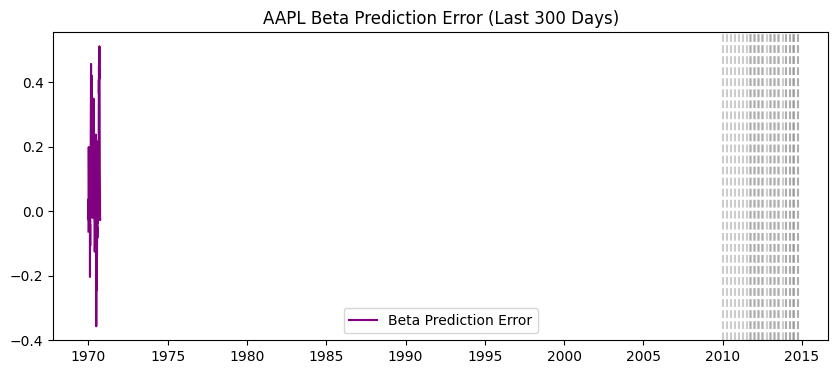

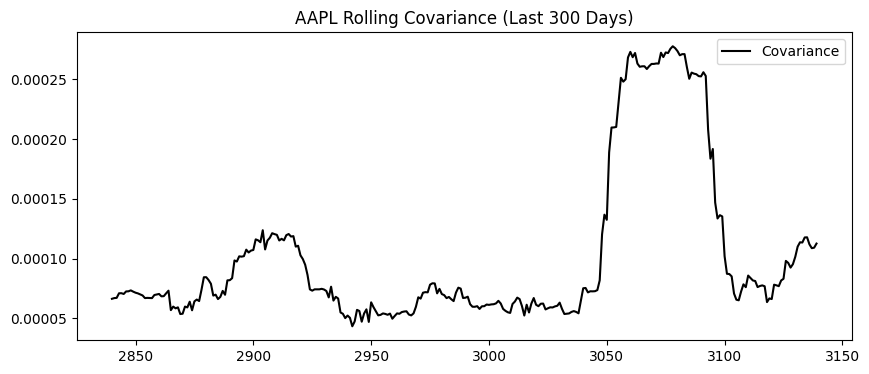

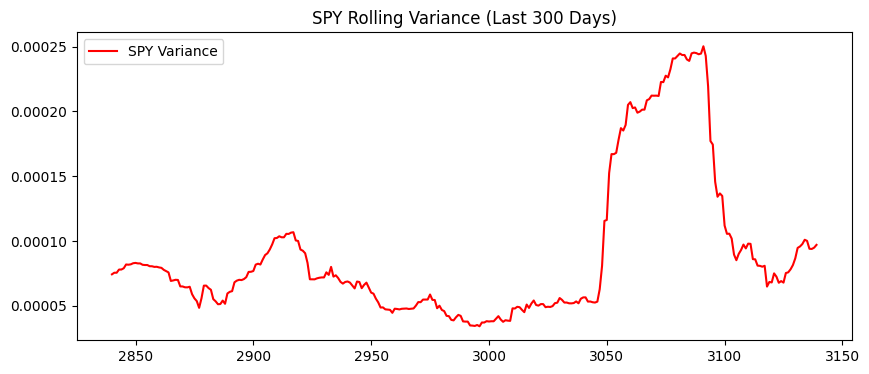

In [40]:
import os, random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime

# ------------------ Deterministic setup ------------------
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["PYTHONHASHSEED"] = "0"
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# ------------------ Load Data ------------------
df = pd.read_csv("beta_project_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Symbol", "Date"]).reset_index(drop=True)

# ------------------ Adjust Prices ------------------
df["AdjClose"] = df["Close"] * df["Adjustment Factor"]

# ------------------ Compute daily log returns ------------------
df["LogReturn"] = np.log(df["AdjClose"] / df["AdjClose"].shift(1))
df = df.dropna().reset_index(drop=True)

# ------------------ SPY as market reference ------------------
window = 45
spy = df[df["Symbol"] == "SPY"].copy()
spy["SPY_Var"] = spy["LogReturn"].rolling(window).var()
spy["SPY_Vol"] = spy["LogReturn"].rolling(window).std()
spy["SPY_Mean"] = spy["LogReturn"].rolling(window).mean()
spy = spy[["Date", "SPY_Var", "SPY_Vol", "SPY_Mean", "LogReturn"]].rename(columns={"LogReturn": "SPY_LogReturn"})

# ------------------ Merge SPY metrics into each stock ------------------
merged = df.merge(spy, on="Date", how="inner")
merged = merged[merged["Symbol"] != "SPY"].reset_index(drop=True)

# ------------------ Compute stable covariance, variance, and beta ------------------
merged["Stock_Vol"] = merged.groupby("Symbol")["LogReturn"].transform(lambda x: x.rolling(window).std())
merged["Stock_Mean"] = merged.groupby("Symbol")["LogReturn"].transform(lambda x: x.rolling(window).mean())
merged["LogReturn_demean"] = merged["LogReturn"] - merged["Stock_Mean"]
merged["SPY_demean"] = merged["SPY_LogReturn"] - merged["SPY_Mean"]

merged["Rolling_Corr"] = merged.groupby("Symbol").apply(
    lambda g: g["LogReturn_demean"].rolling(window).corr(g["SPY_demean"])
).reset_index(level=0, drop=True)

merged["Cov"] = merged["Rolling_Corr"] * merged["Stock_Vol"] * merged["SPY_Vol"]
merged["Var_SPY"] = merged["SPY_Var"]
merged["Beta"] = merged["Cov"] / merged["Var_SPY"]
merged = merged.dropna().reset_index(drop=True)

# ------------------ Feature Engineering ------------------
def make_features(df, window=45):
    df["Momentum"] = df["AdjClose"].pct_change(window)
    df["Vol_Ratio"] = df["Stock_Vol"] / df["SPY_Vol"]
    df["Lagged_Beta"] = df["Beta"].shift(1)
    return df

merged = merged.groupby("Symbol").apply(make_features, window).reset_index(drop=True)
merged = merged.dropna().reset_index(drop=True)

# ------------------ Select stock (example: AAPL) ------------------
stock = "AAPL"
stock_df = merged[merged["Symbol"] == stock].copy()

features = ["Rolling_Corr", "Stock_Vol", "SPY_Vol", "Momentum", "Vol_Ratio", "Lagged_Beta"]
X = stock_df[features].values
y = stock_df["Beta"].values

# ------------------ Prepare sequences for LSTM ------------------
lookback = 30
X_seq, y_seq = [], []
for i in range(lookback, len(X)):
    X_seq.append(X[i - lookback:i])
    y_seq.append(y[i])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)

split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# ------------------ Normalize features ------------------
scaler = StandardScaler()
nsamp, nsteps, nfeat = X_train.shape
X_train = X_train.reshape(-1, nfeat)
X_test = X_test.reshape(-1, nfeat)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = X_train.reshape(nsamp, nsteps, nfeat)
X_test = X_test.reshape(X_test.shape[0]//nsteps, nsteps, nfeat)

# ------------------ LSTM Model ------------------
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(lookback, len(features)), return_sequences=False),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

# ------------------ Predictions ------------------
y_pred = model.predict(X_test).flatten()
mse = mean_squared_error(y_test, y_pred)
print(f"{stock} Beta Prediction MSE:", mse)

# ------------------ Plot Beta Prediction Error ------------------
plt.figure(figsize=(10,4))
plt.plot(y_test[-300:] - y_pred[-300:], label="Beta Prediction Error", color='purple')
plt.title(f"{stock} Beta Prediction Error (Last 300 Days)")
plt.legend()

# ------------------ Add event markers ------------------
event_dates = [
    "1/15/2010","4/9/2010","7/9/2010","10/15/2010","1/7/2011","4/8/2011","7/8/2011","9/24/2011",
    "10/14/2011","12/27/2011","1/13/2012","3/31/2012","4/13/2012","6/30/2012","7/13/2012","10/19/2012",
    "12/29/2012","1/11/2013","3/30/2013","4/12/2013","6/29/2013","7/12/2013","10/18/2013","12/30/2013",
    "1/10/2014","3/29/2014","4/11/2014","6/9/2014","6/28/2014","7/11/2014","9/27/2014","10/10/2014"
]
event_dates = [datetime.strptime(d, "%m/%d/%Y") for d in event_dates]

for d in event_dates:
    plt.axvline(x=d, color='grey', linestyle='--', alpha=0.4)

plt.show()

# ------------------ Plot Underlying Covariance and Variance ------------------
plt.figure(figsize=(10,4))
plt.plot(stock_df["Cov"].iloc[-300:], label="Covariance", color='black')
plt.title(f"{stock} Rolling Covariance (Last 300 Days)")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(stock_df["Var_SPY"].iloc[-300:], label="SPY Variance", color='red')
plt.title("SPY Rolling Variance (Last 300 Days)")
plt.legend()
plt.show()


C:\Users\likapichu\AppData\Local\Temp\ipykernel_31012\1477472277.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged["Rolling_Corr"] = merged.groupby("Symbol").apply(
C:\Users\likapichu\AppData\Local\Temp\ipykernel_31012\1477472277.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged = merged.groupby("Symbol").apply(make_features, window).reset_index(drop=True)
c:\Users\likapichu\anaconda3\Li

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
AAPL Beta Prediction MSE: 0.04317517530449564


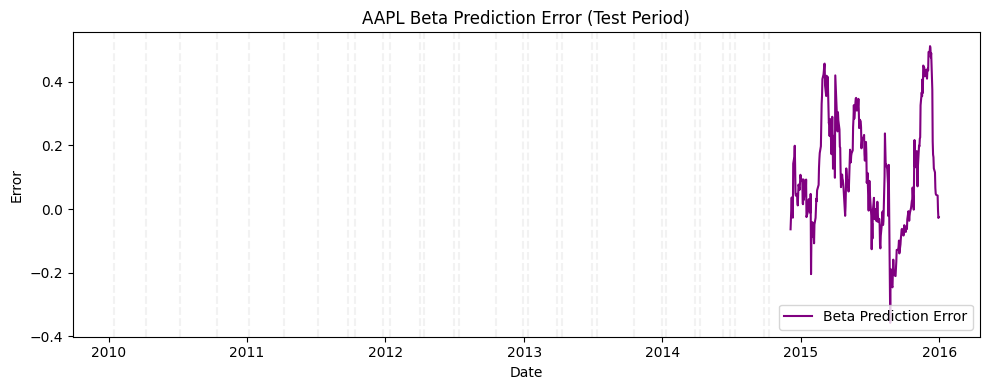

Date range in dataset: 2010-07-15 00:00:00 → 2015-12-31 00:00:00
Date range in test period: 2014-12-05 00:00:00 → 2015-12-31 00:00:00
Usable samples: 1377, Train: 1077, Test: 270


In [ ]:
import os, random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime

# ------------------ Deterministic setup ------------------
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["PYTHONHASHSEED"] = "0"
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# ------------------ Load Data ------------------
df = pd.read_csv("beta_project_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Symbol", "Date"]).reset_index(drop=True)

# ------------------ Adjust Prices ------------------
df["AdjClose"] = df["Close"] * df["Adjustment Factor"]

# ------------------ Compute daily log returns ------------------
df["LogReturn"] = np.log(df["AdjClose"] / df["AdjClose"].shift(1))
df = df.dropna().reset_index(drop=True)

# ------------------ Identify SPY (market index) ------------------
spy = df[df["Symbol"] == "SPY"].copy()
window = 45
spy["SPY_Var"] = spy["LogReturn"].rolling(window).var()
spy["SPY_Vol"] = spy["LogReturn"].rolling(window).std()
spy["SPY_Mean"] = spy["LogReturn"].rolling(window).mean()
spy = spy[["Date", "SPY_Var", "SPY_Vol", "SPY_Mean", "LogReturn"]].rename(columns={"LogReturn": "SPY_LogReturn"})

# ------------------ Merge SPY metrics into all stocks (left join, keep continuity) ------------------
merged = df.merge(spy, on="Date", how="left")
merged[["SPY_LogReturn", "SPY_Var", "SPY_Vol", "SPY_Mean"]] = merged[
    ["SPY_LogReturn", "SPY_Var", "SPY_Vol", "SPY_Mean"]
].ffill()

# ------------------ Compute rolling covariance and Beta ------------------
merged["Stock_Vol"] = merged.groupby("Symbol")["LogReturn"].transform(lambda x: x.rolling(window).std())
merged["Stock_Mean"] = merged.groupby("Symbol")["LogReturn"].transform(lambda x: x.rolling(window).mean())
merged["LogReturn_demean"] = merged["LogReturn"] - merged["Stock_Mean"]
merged["SPY_demean"] = merged["SPY_LogReturn"] - merged["SPY_Mean"]

merged["Rolling_Corr"] = merged.groupby("Symbol").apply(
    lambda g: g["LogReturn_demean"].rolling(window).corr(g["SPY_demean"])
).reset_index(level=0, drop=True)

merged["Cov"] = merged["Rolling_Corr"] * merged["Stock_Vol"] * merged["SPY_Vol"]
merged["Var_SPY"] = merged["SPY_Var"]
merged["Beta"] = merged["Cov"] / merged["Var_SPY"]
merged = merged.dropna().reset_index(drop=True)

# ------------------ Feature Engineering ------------------
def make_features(df, window=45):
    df["Momentum"] = df["AdjClose"].pct_change(window)
    df["Vol_Ratio"] = df["Stock_Vol"] / df["SPY_Vol"]
    df["Lagged_Beta"] = df["Beta"].shift(1)
    return df

merged = merged.groupby("Symbol").apply(make_features, window).reset_index(drop=True)
merged = merged.dropna().reset_index(drop=True)

# ------------------ Select stock for training (example: AAPL) ------------------
stock = "AAPL"
stock_df = merged[merged["Symbol"] == stock].copy()

features = ["Rolling_Corr", "Stock_Vol", "SPY_Vol", "Momentum", "Vol_Ratio", "Lagged_Beta"]
X = stock_df[features].values
y = stock_df["Beta"].values

# ------------------ Prepare sequences for LSTM ------------------
lookback = 30
X_seq, y_seq = [], []
for i in range(lookback, len(X)):
    X_seq.append(X[i - lookback:i])
    y_seq.append(y[i])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# ------------------ Train/Test Split ------------------
split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# ------------------ Normalize features ------------------
scaler = StandardScaler()
nsamp, nsteps, nfeat = X_train.shape
X_train = X_train.reshape(-1, nfeat)
X_test = X_test.reshape(-1, nfeat)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = X_train.reshape(nsamp, nsteps, nfeat)
X_test = X_test.reshape(X_test.shape[0] // nsteps, nsteps, nfeat)

# ------------------ LSTM Model ------------------
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(lookback, len(features)), return_sequences=False),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

# ------------------ Predictions ------------------
y_pred = model.predict(X_test).flatten()
mse = mean_squared_error(y_test, y_pred)
print(f"{stock} Beta Prediction MSE:", mse)



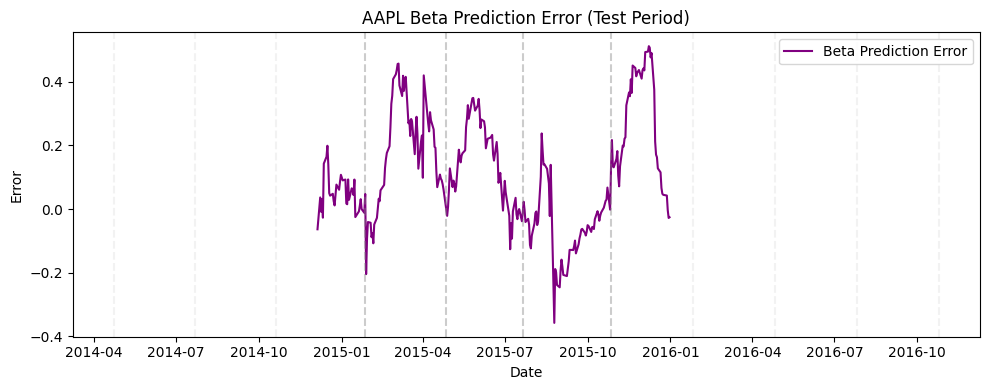

Date range in dataset: 2010-07-15 00:00:00 → 2015-12-31 00:00:00
Date range in test period: 2014-12-05 00:00:00 → 2015-12-31 00:00:00
Usable samples: 1377, Train: 1077, Test: 270


In [49]:

# ------------------ Align test dates ------------------
date_targets = stock_df["Date"].iloc[lookback:].reset_index(drop=True)
test_dates = date_targets.iloc[split:]
min_len = min(len(test_dates), len(y_test), len(y_pred))
test_dates = test_dates.iloc[-min_len:]
y_test = y_test[-min_len:]
y_pred = y_pred[-min_len:]

# ------------------ Plot Beta Prediction Error ------------------
plt.figure(figsize=(10, 4))
plt.plot(test_dates, y_test - y_pred, label="Beta Prediction Error", color="purple")
plt.title(f"{stock} Beta Prediction Error (Test Period)")
plt.xlabel("Date")
plt.ylabel("Error")
plt.legend()

# turn into array 
# ------------------ Event markers ------------------
event_dates = ["4/23/2014", "7/22/2014", "10/20/2014", "1/27/2015", "4/27/2015", "7/21/2015", "10/27/2015", "1/26/2016", "4/26/2016", "7/26/2016", "10/25/2016"]
event_dates = [datetime.strptime(d, "%m/%d/%Y") for d in event_dates]
for d in event_dates:
    alpha_level = 0.4 if test_dates.min() <= d <= test_dates.max() else 0.1
    plt.axvline(x=d, color="grey", linestyle="--", alpha=alpha_level)

plt.tight_layout()
plt.show()

# ------------------ Diagnostics ------------------
print(f"Date range in dataset: {stock_df['Date'].min()} → {stock_df['Date'].max()}")
print(f"Date range in test period: {test_dates.min()} → {test_dates.max()}")
print(f"Usable samples: {len(stock_df)}, Train: {len(y_train)}, Test: {len(y_test)}")
